# Flow-based generative models
---

## Введение

В задачах генерации часто можно встретить, что объекты генерируются из нормального распределения. Таким образом задача генерации сводится к нахождению такой функции, которая переводит вектора $z$ нормального распределения в вектора $x$ реального распределения (того, что хотим генерировать). На картинке ниже показано как разные модели решают эту задачу.

<figure>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/three-generative-models.png" alt="Примеры схем генеративных моделй" style="width:60%">
<figcaption align = "center">Примеры схем генеративных моделй</figcaption>
</figure>

У каждого подхода есть свои проблемы, но главная проблема GAN и VAE заключается в том, что при обучении никак не фигурирует реальное распределение объектов $x$. Нормализирующие потоки предлягают довольно элегантное решение этой проблемы.

__Задача:__

Построить модель, критерий обучения которой включал бы в себя связь распределения $x$ с распределением $z$.

__Идея:__

Построим модель преобразующую простое распределение в реальное при помощи последовательных преобразований обратимыми функциями, которые будем называть "потоками". Ниже на рисунке представлена иллюстрация этого процесса

<figure>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" alt="Примеры схем генеративных моделй" style="width:100%">
<figcaption align = "center">Иллюстрация преобразования нормально распределенного z0 в zK из реального  распределения.</figcaption>
</figure>

Благодаря наличию обратимых потоков, плотность $p_x = p_K(z_K)$ пожно расписать через простую плотнсть нормального распределения $p_0(z_0)$ как
$$
p_x = p_K(z_K) = p_0(z_0)\prod\limits_{i=1}^K\left|\det\dfrac{df_i}{dz_{i-1}}\right|^{-1}
$$
и логарифмируя правую и левую части можно получить
$$
\log p_x = \log p_K(z_K) = \log p_0(z_0) - \sum\limits_{i=1}^K\log\left|\det\dfrac{df_i}{dz_{i-1}}\right|
$$
где $\frac{df_i}{dz_{i-1}}$ — Якобиан, матрица частных производных функции, а $\det\frac{df_i}{dz_{i-1}}$ — ее определитель, а $K$ — число потоков.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
from matplotlib import gridspec
from sklearn.datasets import make_circles, make_moons

import warnings
warnings.filterwarnings("ignore")

In [2]:
class NormalizingFlowsModel(nn.Module):
    """Модель рассчета нормализующих потоков
    Parameters
    ----------
    flows: torch.nn.ModuleList
        Список потоков, применяющихся последовательно
    """
    def __init__(self, flows: nn.ModuleList):
        super().__init__()
        self.flows = flows

    def forward(self, x: torch.Tensor):
        """
        Parameters
        ----------
        x: torch.Tensor
            Тензор исходного распределения признакового пространства

        Returns
        -------
        z: torch.Tensor
            Тензор ростого распределения латентнго пространства
        log_det_jac: torch.Tensor
            Тензор суммы логарифмов определителей Якобиана потока f: p(X) -> q(Z)
        """
        log_det_jac = 0
        z = x
        for flow in self.flows:
            z, ldj = flow(z)
            log_det_jac = log_det_jac + ldj
        return z, log_det_jac

    def inverse(self, z: torch.Tensor):
        """
        Parameters
        ----------
        z: torch.Tensor
            Тензор ростого распределения латентнго пространства

        Returns
        -------
        x: torch.Tensor
            Тензор исходного распределения признакового пространства
        """
        log_det_jac = 0
        x = z
        for flow in self.flows[::-1]:
            x, ldj = flow.inverse(x)
            log_det_jac = log_det_jac + ldj
        return x, log_det_jac

## Постановка оптимизационной задачи

Обучать такую модель будем через минимизацию отрицательного логарифма функции правдоподобия. Получить ее просто, так как у нас уже есть формула рассчета $p_K(z_K)$.
$$
\mathcal{L} = - \dfrac{1}{N}\sum\limits_{j=1}^N \log p_K(z_K^{(j)}) = - \dfrac{1}{N}\sum\limits_{j=1}^N \left[\log p_0(z_0^{(j)}) - \sum\limits_{i=1}^K \log\left|\det\dfrac{df_i}{dz_{i-1}}\right|^{(j)}\right]
$$
где $N$ — число элементов выборки.

При этом основное требование к функции потока $f_i$ — она должна быть легко обратима и ее Якобиан должен легко считаться.

In [3]:
class NLLoss(nn.Module):
    """Функция потерь отрицательного логарифма правдоподобия
    """

    def __init__(self, x_size, loc: float = 0., scale: float = 1.):
        super().__init__()
        self.coef = np.prod(x_size)
        self.prior = torch.distributions.Normal(0, 1)

    def forward(self, z: torch.Tensor, log_det_jac: torch.Tensor):
        """
        Parameters
        ----------
        z: torch.Tensor
            Тензор латентного пространства
        log_det_jac: torch.Tensor
            Логарифм определителя Якобиана

        Returns
        -------
        loss: torch.Tensor
            Значение функции потерь
        """
        log_prob_z = self.prior.log_prob(z).flatten(1).sum(-1)
        loss = - (log_det_jac + log_prob_z).mean()
        loss = loss / self.coef
        return loss

## Affine coupling layer

Теперь рассмотрим используемые потоки. Самым основным потоком можно считать __Affine coupling layer__. Задается он следующим образом
1. Первые $d$ шагов ничего не происходит (эквивалентное преобразование)
2. Начиная с шага $d+1$ применяется аффинное преобразование вида

$$
f =
\begin{cases}
y_i = x_i,~\forall i=1,2,\dots,d \\
y_i = x_i \odot \exp(s(x_{i-d})) + t(x_{i-d}),~\forall i=d+1,\dots,D
\end{cases}
$$

где $s(\cdot)$ — масштабирование, $t(\cdot)$ — смещение, а $\odot$ — поэлементное умножение. Для того чтобы половина вектора не проходила от потока к потоку тривиальное преобразование (первое в системе), принято чередовать их местами.

Однако обычно чередование первого и второго уравнения системы можно представить в виде бинарной маски $b$. С ее помощью афинное преобразование можно переписать как
$$
y = b\odot x + (1 - b)\odot\left(x \odot \exp(s(b\odot x)) + t(b\odot  x)\right)
$$

И тогда маску можно уже задать разную. Чаще всего ипользуют "шахматную" или "канальную" маски.

<p align="center">
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/tutorial_notebooks_tutorial11_NF_image_modeling_33_1.svg" alt="Sublime's custom image"/>
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/tutorial_notebooks_tutorial11_NF_image_modeling_33_2.svg" alt="Sublime's custom image"/>
</p>

In [4]:
class AffineCouplingLayer(nn.Module):

    def __init__(self, scale: nn.Module, translation: nn.Module, mask: torch.Tensor):
        super().__init__()

        self.scale = scale
        self.translation = translation
        self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, x: torch.Tensor):
        b = self.mask
        y = b * x
        s = self.scale(y)
        t = self.translation(y)
        z = y + (1 - b) * (x * torch.exp(s) + t)
        log_det_jac = ((1 - b) * s).flatten(start_dim=1).sum(-1)
        return z, log_det_jac

    def inverse(self, z: torch.Tensor):
        b = self.mask
        y = b * z
        s = self.scale(y)
        t = self.translation(y)
        x = y + (1 - b) * ((z - t) * torch.exp(-s))
        log_det_jac = ((1 - b) * (-s)).flatten(start_dim=1).sum(-1)
        return x, log_det_jac

In [5]:
def create_mask(shape: tuple, axis: int, reverse: bool = False):
    """Создаем маску чередования
    Parameters
    ----------
    shape: tuple
        Размерность маски
    axis: int
        Ось относительно которой происходит чередование. max_axis + 1 — шахматная маска
    reverse: bool
        Поменять порядок нулей и елиниц в маске

    Returns
    -------
    mask: torch.Tensor
        Полученная маска
    """
    slices = [slice(0, num) for num in shape]
    m1 = np.mgrid[slices]
    m2 = np.indices((len(shape), *shape)).sum(axis=0)
    mask = torch.from_numpy(np.vstack((m1, m2)))
    mask = mask[axis]
    mask = mask % 2
    return 1 - mask if reverse else mask

## Эксперимент с распределением

Для начала попробуем провести эксперимент с двумерным распределением. В качестве распределения возьмем `make_moons` из `scikit-learn`.

In [6]:
class Transform(nn.Module):

    def __init__(self, inp: int, hidden_dim: int, use_scale: bool = False):
        super().__init__()

        self.use_scale = use_scale
        self.transform = nn.Sequential(
            nn.Linear(inp, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, inp),
        )
        if self.use_scale:
            self.scale = nn.Parameter(torch.Tensor(inp))
            torch.nn.init.normal_(self.scale)

    def forward(self, x):
        x = self.transform(x)
        if self.use_scale:
            x = F.relu(x)
            x = x * self.scale
        return x

In [7]:
def loss_plot(loss, ax=None):
    ax = plt.subplot() if ax is None else ax
    ax.plot(loss)
    ax.grid(axis='y')
    ax.set_ylabel('Loss values')
    ax.set_xlabel('Epoches')
    ax.set_title('Loss')
    return ax

def points_plot(x, z, inverse: bool = False, axs = None):
    axs = plt.subplots(n_col=2) if axs is None else axs
    ax1, ax2 = axs
    ax1.scatter(x[:, 0], x[:, 1], s=1)
    ax2.scatter(z[:, 0], z[:, 1], s=1)
    ax1.set_title('Gen sample $x$' if inverse else 'Real sample $x$')
    ax2.set_title('Real sample $z$' if inverse else 'Gen sample $z$')
    return ax1, ax2

def simple_experiment(model, optimizer, criterion, distr, prior, epoches: int = 30, **distr_kwargs):
    pbar = tqdm(total=epoches)
    total_loss = []
    with pbar:
        for i in range(epoches):

            sample, _ = distr(**distr_kwargs)
            sample = torch.from_numpy(sample).float()

            optimizer.zero_grad()
            z, log_det_jac = model(sample.to(device))
            loss = criterion(z, log_det_jac)
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_description("Epoch %i, Loss: %.4f" %(i+1, loss.item()))
            total_loss.append(loss.item())

    fig = plt.figure(tight_layout=True, figsize=(5, 7))
    gs = gridspec.GridSpec(3, 2)

    ax1 = fig.add_subplot(gs[0, :])
    loss_plot(total_loss, ax=ax1)

    z = prior.sample((5000, )).to(device)
    x = model.inverse(z)[0]
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    points_plot(x.cpu().detach(), z.cpu().detach(), inverse=True, axs=[ax2, ax3])

    x = make_moons(n_samples=5000, noise=0.05)[0]
    x = torch.from_numpy(x).float().to(device)
    z = model(x)[0]
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[2, 1])
    points_plot(x.cpu().detach(), z.cpu().detach(), inverse=False, axs=[ax2, ax3])

    plt.show()

    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

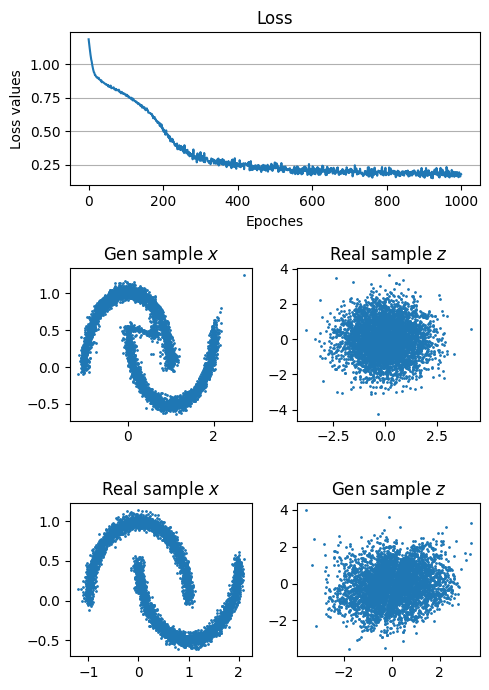

In [8]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512

flows = nn.ModuleList([
    AffineCouplingLayer(
        Transform(2, 128, use_scale=True),
        Transform(2, 128),
        create_mask((2, ), 1, reverse=bool(i % 2))
    )
    for i in range(8)
])
model = NormalizingFlowsModel(flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = NLLoss((2, ))
prior = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

model = simple_experiment(model, optimizer, criterion, make_moons, prior, epoches=1000, n_samples=512, noise=0.05)

Интересно посмотреть на то, как от потока к потоку менялось распределение $p_i(z_i)$. Его мы сможем посмотреть воспользовавшись формулой соответствия $p_i(z_i)$ к нормальному $p_0(x_0)$
$$
p_i(z_i) = p_0(z_0)\prod_{k=i}^K \det\left|\dfrac{df_k}{dz_{k-1}}\right|
$$
Видим, что преобразование $p_0(z_0)$ в $p_K(z_K)$ выглядит довольно хаотично, а последний поток вообще оказывает малое влияние на результат. Вдальнейшем мы еще вернемся к вопросу стабильности нормализующих потоков.

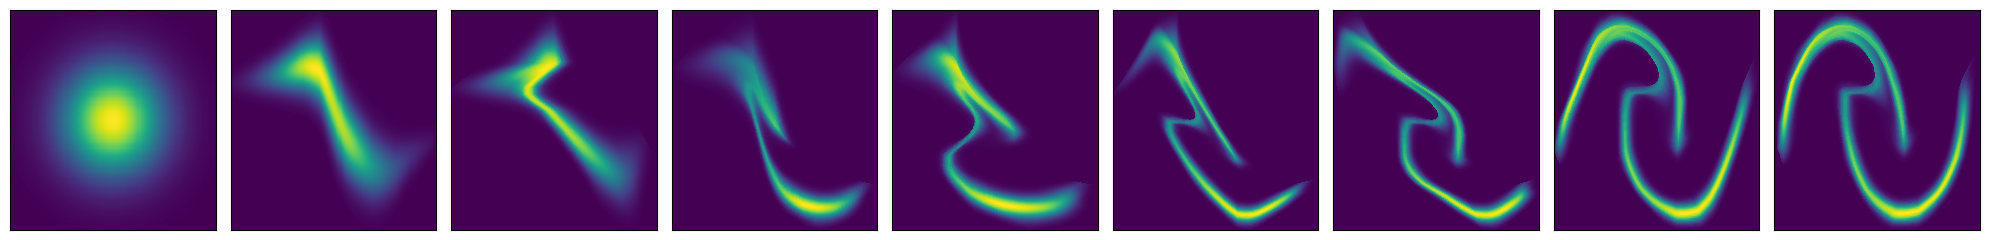

In [9]:
plt.figure(figsize=(20, 2.5), tight_layout=True)
distr = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

n = 200
x = torch.linspace(-3, 3, n)
xx, yy = torch.meshgrid((x, x))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=-1).squeeze()

log_prob_z = distr.log_prob(zz)

ax = plt.subplot(1,9,1)
ax.pcolormesh(xx.view(n, n).data, yy.view(n, n).data, log_prob_z.view(n, n).exp().data)

log_det_jac = 0
x = zz
for i, flow in enumerate(model.flows[::-1]):
    x, ldj = flow.inverse(x.to(device))
    log_det_jac = log_det_jac + ldj.cpu()
    x = x.cpu()

    prob_x = (log_prob_z - log_det_jac).exp()
    ax = plt.subplot(1,9,i+2)
    ax.pcolormesh(x[:, 0].view(n, n).data, x[:, 1].view(n, n).data, prob_x.view(n, n).data)

for ax in plt.gcf().axes:
    ax.set_facecolor(plt.cm.viridis(0.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Генерация изобрадений

Для решения задачи генерации изображений возьмем MNIST. Для простоты уменьшим его разрешение до 1x16x16. Также оставим значения как в кодировке в отрезке $[0, 255]$ и уменьшим число примеров в 2 раза.

In [10]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Resize, Compose, Pad, RandomAffine
from torchvision.utils import make_grid

In [28]:
transform = Compose([
    Resize(20),
    ToTensor(),
    Lambda(lambda t: 255 * t),
])

mnist = MNIST('../data/', download=True, transform=transform)
train, _ = torch.utils.data.random_split(mnist, [20000, 40000])
train = DataLoader(train, batch_size=256, shuffle=True, drop_last=True)

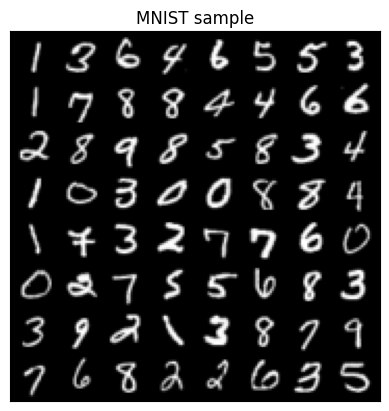

In [29]:
sample = next(iter(train))[0][:64]
plt.imshow(ToPILImage()(make_grid(sample.float(), normalize=True)))
plt.xticks([])
plt.yticks([])
plt.title('MNIST sample')
plt.show()

### Изменение размерности

В нормализующих потоках есть проблема с понижением размерности. Если в обычных сетях мы можем менять размерности входа и выхода довольно свободно, то афинный поток требует от нас равных размерностей входа и выхода.

Соответственно менять размерность можно только между потоками, но встает вопрос, как это сделать, какие пиксели выкинуть из изображения, а какие оставить.

Для нормализующих потоков вводят две трансформации _squieeze_ и _split_.

<p align="center">
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/Squeeze_operation.svg" alt="Sublime's custom image" style="width:100%"/>
  <figcaption align = "center"><a href="https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html#Squeeze-and-Split">Иллюстрация трансформации Squeeze</a></figcaption>
  </figure>
</p>

То есть Squeeze перемешивает пиксели изображения, трансформируя размерность
$$C\times H\times W\to 4C\times\frac{H}{2}\times\frac{W}{2}$$

Операция Split разбивает изображение на две части по каналам, то есть трансформирует размерность как
$$2C\times H\times W\to C\times H\times W$$

In [13]:
class SqueezeFlow(nn.Module):

    def forward(self, x):
        B, C, H, W = x.size()
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, 4*C, H//2, W//2)
        return x, torch.zeros(x.size(0), device=x.device)

    def inverse(self, z):
        B, C, H, W = z.size()
        z = z.reshape(B, C//4, 2, 2, H, W)
        z = z.permute(0, 1, 4, 2, 5, 3)
        z = z.reshape(B, C//4, H*2, W*2)
        return z, torch.zeros(z.size(0), device=z.device)

In [14]:
class SplitFlow(nn.Module):

    def __init__(self, prior=None):
        super().__init__()
        if prior is None:
            self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        else:
            self.prior = prior

    def forward(self, x):
        x, x_split = x.chunk(2, dim=1)
        ldj = self.prior.log_prob(x_split).flatten(1).sum(-1)
        return x, ldj

    def inverse(self, z):
        z_split = self.prior.sample(sample_shape=z.shape).to(device)
        z = torch.cat([z, z_split], dim=1)
        ldj = self.prior.log_prob(z_split).flatten(1).sum(-1)
        return z, ldj

### Деквантизация распределения

In [15]:
class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def __forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

    def forward(self, x):
        return self.__forward(x, 0, reverse=False)

    def inverse(self, z):
        return self.__forward(z, 0, reverse=True)

### Архитектура сети

Так как работаем с изображениями, в афинном потоке будем использовать сверточные сети. Частые элементы архитектуры в таких задачах следующие:
1. Конкатинирующий ELU
2. Нормирование по каналам
3. Стробирующие свертки

Разберем каждый пункт подробнее



#### Конкатинирующий ELU

Тут все просто. Входной тензор $x$, который подается в $\text{ELU}$, подается дважды, но второй раз отрицательный. То есть формулой выглядит так
$$
\text{ConcatELU}(x) = [\text{ELU}(x), \text{ELU}(-x)]
$$

<p align="center">
  <img src="https://pytorch.org/docs/stable/_images/ELU.png" alt="Sublime's custom image" style="width:50%"/>
  <figcaption align = "center"><a href="https://pytorch.org/docs/stable/generated/torch.nn.ELU.html">График функции активации ELU</a></figcaption>
  </figure>
</p>

In [16]:
class ConcatELU(nn.Module):
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

#### Нормализация по каналам
Аналогично нормализации по батчу, то есть преобразование
$$x ← \dfrac{x - \mu}{\sqrt{\sigma^2 + ɛ}}$$

Только размерность $\mu$ и $\sigma$ не по размеру батча, а по числу каналов $C$. Следовательно и инициализация выполняется так, чтобы  
$$\mathbb{E}_C[x] = 0, ~\text{Var}_C[x]=1$$


In [17]:
class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        super().__init__()
        self.sigma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.mu = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.sigma + self.mu
        return y

#### Стробирующие свертки

In [18]:
class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, num_layers=3, use_scale=False):
        super().__init__()
        self.use_scale = use_scale
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_in, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

        if self.use_scale:
            self.scale = nn.Parameter(torch.Tensor(c_in, 1, 1))
            torch.nn.init.normal_(self.scale)

    def forward(self, x):
        x = self.nn(x)
        if self.use_scale:
            x = F.tanh(x) * self.scale
        return x

In [19]:
def mnist_experiment(dataloader, model, optimizer, criterion, epoches: int = 30):
    pbar = tqdm(total=epoches)
    total_loss = []
    prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    with pbar:
        for i in range(epoches):
            epoch_loss = []
            for real_sample, _ in dataloader:
                optimizer.zero_grad()
                z, log_det_jac = model(real_sample.to(device))
                loss = criterion(z, log_det_jac)
                loss = loss / 64
                epoch_loss.append(loss.item())
                total_loss.append(loss.item())
                loss.backward()
                optimizer.step()

            pbar.update(1)
            pbar.set_description("Epoch %i, Loss: %.4f" %(i+1, np.mean(epoch_loss)))

    return model, total_loss

In [30]:
def create_multiscale_flow():
    flow_layers = [Dequantization()]
    flow_layers += [AffineCouplingLayer(
                        GatedConvNet(1, 32, use_scale=True),
                        GatedConvNet(1, 32),
                        create_mask((1, 20, 20), 4, (i % 2))
                    ) for i in range(3)]
    flow_layers += [SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(4, 32, use_scale=True),
                            GatedConvNet(4, 32),
                            create_mask((4, 10, 10), 0, (i % 2))
                        )]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(8, 32, use_scale=True),
                            GatedConvNet(8, 32),
                            create_mask((8, 5, 5), 0, (i % 2))
                        )]

    flow_model = nn.ModuleList(flow_layers)
    return flow_model

In [31]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

flows = create_multiscale_flow()
model = NormalizingFlowsModel(flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , weight_decay=5 * 1e-5
criterion = NLLoss((1, 20, 20))

model, loss = mnist_experiment(train, model, optimizer, criterion, epoches=25)

  0%|          | 0/25 [00:00<?, ?it/s]

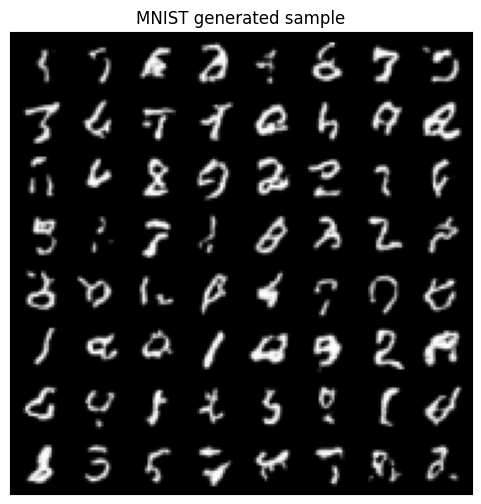

In [36]:
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
z = prior.sample((64, 8, 5, 5)).to(device)
gen_imgs = model.inverse(z)[0]

plt.figure(figsize=(6, 6))
plt.imshow(ToPILImage()(make_grid(gen_imgs.float(), normalize=True)))
plt.title('MNIST generated sample')
plt.xticks([])
plt.yticks([])
plt.show()

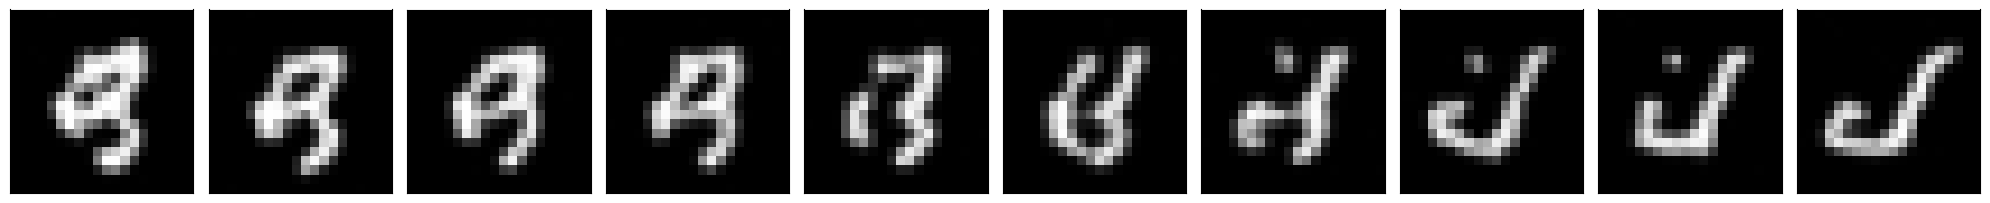

In [35]:
plt.figure(figsize=(20, 2.5), tight_layout=True)

z1, z2 = prior.sample((2, 8, 5, 5)).to(device)
for i, alpha in enumerate(torch.arange(0, 1, 0.1)):
    z = alpha * z1 + (1 - alpha) * z2
    x = model.inverse(z.unsqueeze(0))[0][0]
    plt.subplot(1, 10, i+1)
    plt.imshow(ToPILImage()(x))
for ax in plt.gcf().axes:
    ax.set_facecolor(plt.cm.viridis(0.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Упражнения

1. Поиграться с параметрами (число потоков, число скрытых слоев в них).
2. Обучить MNIST на всей выборке без изменения размера.
3. В задании с двумерным распределением заменить `make_moons` например на `make_circles` или другой двумерный самплер точек.
4. Попробовать заменить архитектуру сети в афинном преобразовании.

## Полезные ссылки

- [UvA DL Notebooks Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html)
- [Flow-based Deep Generative Models](https://lilianweng.github.io/posts/2018-10-13-flow-models)